# Aquaseca basic domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [123]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## 2. Discretization and other inputs

In [124]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

#ztop = 100
ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)
#print(type(ztop))
#print(ztop.shape)
#print(ztop[0,:])
zbot = 0.     #bottom elevation


## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
Sy = 0.1        #assign specific yield
uncnf = 1       #0=confined, >0 = unconfined

## ET
ET = 1e-5 #m/day
ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
rip_ET= 5e-5  #riparian zone
rip_locxy= [[0,21000],[23000,0]]
extinction_depth = 10 #m
#print(ET_locxy)
#print(rip_loc)

# ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows

# ET_rows2=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
# ET_cols2=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx))

ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
ET_cols_forced = (26.0, 49.0)

ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 
#print("ET location(col, row)", ET_cols,ET_rows)
#print("ETrows_forced:", ET_rows_forced)
#print("ETrows:", ET_rows)
#print("ETcols:", ET_cols)
#print("ETrows2:", ET_rows2)
#print("ETcols2:", ET_cols2)

rip_rows_forced = (21.0, 28.0)  #forced riparian area
rip_cols_forced = (1.0, 49.0)


# rip_rows=(np.floor(nrow-rip_locxy[1][1]/dy),np.floor(nrow-rip_locxy[0][1]/dy)) #convert the y locations to rows
# rip_cols=(np.floor(rip_locxy[0][0]/dx),np.floor(rip_locxy[1][0]/dx)) #convert the y locations to rows
rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), 
        int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 
#print("Riparian location(col, row)", rip_cols,rip_rows)

## Recharge
rech=4e-5  #m/d
rechxy=[(0,0),(0,36000)]  #recharge zone

rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
rech_cols_forced = (1.0, 15.0)

# agrech_rows_forced = (28.0, 30.0) #rech zone forced for leftmost 15 cols
# agrech_cols_forced = (18.0, 20.0)
# agrech = 0.00015  #pistachios (1/8th area already included)

rech_zone_forced = np.zeros((1, nrow,ncol))
rech_zone_forced[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),
                 int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
# rech_zone_forced[0, int(agrech_rows_forced[0]):int(agrech_rows_forced[1]),int(agrech_cols_forced[0]):int(agrech_cols_forced[1])]=agrech

rech_rows=(np.floor(nrow-rechxy[1][1]/dy),np.floor(nrow-rechxy[0][1]/dy))
rech_cols=(np.floor(rechxy[0][0]/dx),np.floor(rechxy[1][0]/dx))
#rech_zone=np.zeros(1,nrow,ncol)
#rech_zone[0,int(rech_rows[0]):int(rech_rows[1]),int(rech_cols[0]):int(rech_cols[1])]=rech
print("recharge location(col, row)", rech_cols,rech_rows)

#supply well
pumping = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_row = 29
well_col = 37
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
print("well1 location(layer, col, row, pumping rate)", well)


#MW1
pumping2 = 0 #m3/day 
well2_xy= [25000, 25000] #xy location of well 
well2_row = np.floor((nrow)-(well2_xy[1]/dy)) #convert the y location to a row
well2_col=np.floor(well2_xy[0]/dx)-1 #convert the x location to a column
well2_loc = (0,well2_row, well2_col)
well2 = [0,well2_row, well2_col, pumping2] #Well loc shoudl be layer, row, column
print("well2 location(layer, col, row, pumping rate)", well2)

#MW2
pumping3 = 0 #m3/day 
well3_xy= [12500, 12500] #xy location of well 
well3_row = np.floor((nrow)-(well3_xy[1]/dy)) #convert the y location to a row
well3_col=np.floor(well3_xy[0]/dx) #convert the x location to a column
well3_loc = (0,well3_row, well3_col)
well3 = [0,well3_row, well3_col, pumping3] 
print("well3 location(layer, col, row, pumping rate)", well3)


#irrigation well
pumping4 = 0#-4500 #m3/day 
well4_row = 38 
well4_col = 12 
well4_loc = (0,well4_row, well4_col)
well4 = [0,well4_row, well4_col, pumping4] 
print("well4 location(layer, col, row, pumping rate)", well4)

wel_spd = {0: [well, well2, well3, well4]}
#print(len(wel_spd))

## Boundary conditions
h_right = 70


## Timing
# nper = 1 #number of stress periods 
# steady = [True] #list noting the stress period type

recharge location(col, row) (0.0, 0.0) (14.0, 50.0)
well1 location(layer, col, row, pumping rate) [2, 29, 37, 0]
well2 location(layer, col, row, pumping rate) [0, 25.0, 24.0, 0]
well3 location(layer, col, row, pumping rate) [0, 37.0, 12.0, 0]
well4 location(layer, col, row, pumping rate) [0, 38, 12, 0]


### Boundary Conditions

In [131]:
#read in burn-in head values
print(os.getcwd())
# H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
# H_init[0,:,:] = np.loadtxt('postdev_toplayer_h_init.csv', delimiter=",")
# H_init[1,:,:] = np.loadtxt('postdev_midlayer_h_init.csv', delimiter=",")
# H_init[2,:,:] = np.loadtxt('postdev_botlayer_h_init.csv', delimiter=",")
# print(H_init[2,:,1])

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value
print(H_init[2,:,1])

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

/Users/hardknox47/Desktop/HWRS482/hw482/GroMore_Project/Justin


### Seasons and Stressperiods

In [132]:
sp_peryr = 2   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp1_len = 180  #sp lengths
sp2_len = 180
sim_years = 200
nper = int(sp_peryr*sim_years + 1) # total number of stress periods the +1 is for the steady state start
# nper = int(sp_peryr*sim_years)
print(nper)

#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
steady[0] = True    # initial stress period is steady-state
print(len(steady))

#make an array of period lengths
perlen=np.tile([sp1_len, sp2_len],sim_years)
perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", len(perlen))

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 
#so we can repeat the perlen array
nstp=perlen#/30 #30 for monthly
nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
print("Number of Steps", (nstp))



## Boundary conditions
h_right = 70


401
401
Period lengths 401
Number of Steps [  1 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180 180
 180 180

### Set up varying ET & Pumping

In [150]:
                      
ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
# ET_zone2 = ET_zone * 0 
for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if p == 0:
        ET_dict[p] = ET_zone
    elif int(p % 2) != 0:
        ET_dict[p]=ET_zone
        #print(p)
    else: 
        ET_dict[p] = ET_zone

# #No steady state test
# for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
#     if p == 0:
#         ET_dict[p] = ET_zone2
#     elif int(p % 2) != 0:
#         ET_dict[p]=ET_zone
#         #print(p)
#     else: 
#         ET_dict[p] = ET_zone2


#WELL STRESS PERIODS
#init_well = [well, well2, well3, well4]
#
# wel_spd = {}    
    
# burn = 0 #0 because of the head file read in
# decade = 1
# decade2 = 10 #to calculate pumping after 100 year pumping
# pump = 47

# for strper in range(0, nper):    
#     if strper < burn:
#         pumping = 0
#         wel_spd[strper] = [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
#     elif strper < (burn+decade*20): # 20 for 2 stress periods per 10 years
#         pumping = round(pump * (decade2**1.5)) *-1
#         wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
#     else:
#         decade = decade + 1   
#         decade2 = decade2 +1
#         pumping = round(pump * (decade2**1.5)) *-1
#         wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
    
# #print(wel_spd)

### Layering

In [134]:
## define layer properties 
K_horiz = 10 #m/d
K_vert = 10 #m/d
K_vert2 = 0.0001 #m/d  #K for the middle layer 


## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2
#print(K_horiz)
#print(Kz)

## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

### Stream

In [135]:
#DEFINE RIVERS
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1
k_rivbott = 1000 #river bottom hydraulic conductivity in m/d
sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)

## 3. Run Modflow

In [151]:
#create model object
modelname = "Scenario2"
# moddir="/Applications/MODFLOW/mf2005"
#moddir = "/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
#moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"

m = flopy.modflow.Modflow(modelname, exe_name = moddir)


#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone_forced, ipakcb=53)     #create rch object

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

# #Storage?
# sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(model=m, loading_package=False, save_flows=True, storagecoefficient=None, iconvert=0, ss=Ss, sy=Sy, transient=True)

#Output control - OC 
#spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

# oc_spd = {}
# for kper in range(0,nper):
#     for kstp in range(nstp[kper]):
#         #print(kstp)
#         oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
# # #print(np.shape(oc_spd))oc_spd = {}
oc_spd = {}
for kper in range(1,nper): #nper is 201, this is the key for each entry in oc_spd dict
    oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
#will save the data from the last day in each stress period
#print(np.shape(oc_spd))

oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=5000, iter1=100, relax = 0.95, damp = 0.1)


#write the inputs
m.write_input()   
m.check()


Scenario2 MODEL DATA VALIDATION SUMMARY:
  2 Warnings:
    LPF package: STORAGECOEFFICIENT option is activated, storage values are read storage coefficients
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 401 stress periods

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF p

In [152]:
#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Scenario2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/28 17:41:26

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress p

 Solving:  Stress period:     2    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Wa

 Solving:  Stress period:     3    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:   136    Ground-Wa

 Solving:  Stress period:     4    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:   101    Ground-Wa

 Solving:  Stress period:     5    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:    78    Ground-Wa

 Solving:  Stress period:     6    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:    56    Ground-Wa

 Solving:  Stress period:     7    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:    32    Ground-Wa

 Solving:  Stress period:     7    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:     7    Ground-Wa

 Solving:  Stress period:     8    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:     8    Time step:   161    Ground-Wa

 Solving:  Stress period:     9    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:     9    Time step:   136    Ground-Wa

 Solving:  Stress period:    10    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    10    Time step:   113    Ground-Wa

 Solving:  Stress period:    11    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    11    Time step:    75    Ground-Wa

 Solving:  Stress period:    12    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    12    Time step:    39    Ground-Wa

 Solving:  Stress period:    13    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:    14    Ground-Wa

 Solving:  Stress period:    13    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    13    Time step:   168    Ground-Wa

 Solving:  Stress period:    14    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    14    Time step:   144    Ground-Wa

 Solving:  Stress period:    15    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    15    Time step:   122    Ground-Wa

 Solving:  Stress period:    16    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    16    Time step:    85    Ground-Wa

 Solving:  Stress period:    17    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    17    Time step:    60    Ground-Wa

 Solving:  Stress period:    18    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:    35    Ground-Wa

 Solving:  Stress period:    18    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    18    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:    10    Ground-Wa

 Solving:  Stress period:    19    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    19    Time step:   157    Ground-Wa

 Solving:  Stress period:    20    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    20    Time step:   128    Ground-Wa

 Solving:  Stress period:    21    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    21    Time step:   105    Ground-Wa

 Solving:  Stress period:    22    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    22    Time step:    79    Ground-Wa

 Solving:  Stress period:    23    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:    51    Ground-Wa

 Solving:  Stress period:    23    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    23    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:    10    Ground-Wa

 Solving:  Stress period:    24    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    24    Time step:   142    Ground-Wa

 Solving:  Stress period:    25    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    25    Time step:   104    Ground-Wa

 Solving:  Stress period:    26    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    26    Time step:    66    Ground-Wa

 Solving:  Stress period:    27    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    27    Time step:    36    Ground-Wa

 Solving:  Stress period:    28    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:    15    Ground-Wa

 Solving:  Stress period:    28    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    28    Time step:   176    Ground-Wa

 Solving:  Stress period:    29    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    29    Time step:   146    Ground-Wa

 Solving:  Stress period:    30    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    30    Time step:   121    Ground-Wa

 Solving:  Stress period:    31    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    31    Time step:   100    Ground-Wa

 Solving:  Stress period:    32    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    32    Time step:    79    Ground-Wa

 Solving:  Stress period:    33    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    33    Time step:    50    Ground-Wa

 Solving:  Stress period:    34    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:    29    Ground-Wa

 Solving:  Stress period:    34    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    34    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:     9    Ground-Wa

 Solving:  Stress period:    35    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    35    Time step:   164    Ground-Wa

 Solving:  Stress period:    36    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    36    Time step:   140    Ground-Wa

 Solving:  Stress period:    37    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    37    Time step:   116    Ground-Wa

 Solving:  Stress period:    38    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    38    Time step:    92    Ground-Wa

 Solving:  Stress period:    39    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    39    Time step:    68    Ground-Wa

 Solving:  Stress period:    40    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    40    Time step:    46    Ground-Wa

 Solving:  Stress period:    41    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:    26    Ground-Wa

 Solving:  Stress period:    41    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    41    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:     9    Ground-Wa

 Solving:  Stress period:    42    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    42    Time step:   165    Ground-Wa

 Solving:  Stress period:    43    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    43    Time step:   144    Ground-Wa

 Solving:  Stress period:    44    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    44    Time step:   123    Ground-Wa

 Solving:  Stress period:    45    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    45    Time step:   102    Ground-Wa

 Solving:  Stress period:    46    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    46    Time step:    79    Ground-Wa

 Solving:  Stress period:    47    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    47    Time step:    58    Ground-Wa

 Solving:  Stress period:    48    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    48    Time step:    37    Ground-Wa

 Solving:  Stress period:    49    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:    19    Ground-Wa

 Solving:  Stress period:    49    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    49    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:     5    Ground-Wa

 Solving:  Stress period:    50    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    50    Time step:   156    Ground-Wa

 Solving:  Stress period:    51    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    51    Time step:   106    Ground-Wa

 Solving:  Stress period:    52    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    52    Time step:    84    Ground-Wa

 Solving:  Stress period:    53    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    53    Time step:    66    Ground-Wa

 Solving:  Stress period:    54    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    54    Time step:    49    Ground-Wa

 Solving:  Stress period:    55    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    55    Time step:    28    Ground-Wa

 Solving:  Stress period:    56    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:    13    Ground-Wa

 Solving:  Stress period:    56    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    56    Time step:   172    Ground-Wa

 Solving:  Stress period:    57    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    57    Time step:   151    Ground-Wa

 Solving:  Stress period:    58    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    58    Time step:   117    Ground-Wa

 Solving:  Stress period:    59    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    59    Time step:    90    Ground-Wa

 Solving:  Stress period:    60    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    60    Time step:    70    Ground-Wa

 Solving:  Stress period:    61    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:    61    Time step:    47    Ground-Wa

 Solving:  Stress period:    62    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:    26    Ground-Wa

 Solving:  Stress period:    62    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    62    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:     6    Ground-Wa

 Solving:  Stress period:    63    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    63    Time step:   168    Ground-Wa

 Solving:  Stress period:    64    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    64    Time step:   140    Ground-Wa

 Solving:  Stress period:    65    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    65    Time step:   123    Ground-Wa

 Solving:  Stress period:    66    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    66    Time step:   106    Ground-Wa

 Solving:  Stress period:    67    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    67    Time step:    88    Ground-Wa

 Solving:  Stress period:    68    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:    68    Time step:    66    Ground-Wa

 Solving:  Stress period:    69    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    69    Time step:    43    Ground-Wa

 Solving:  Stress period:    70    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:    22    Ground-Wa

 Solving:  Stress period:    70    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    70    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:     8    Ground-Wa

 Solving:  Stress period:    71    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    71    Time step:   169    Ground-Wa

 Solving:  Stress period:    72    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:    72    Time step:   147    Ground-Wa

 Solving:  Stress period:    73    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:    73    Time step:   128    Ground-Wa

 Solving:  Stress period:    74    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    74    Time step:   112    Ground-Wa

 Solving:  Stress period:    75    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    75    Time step:    97    Ground-Wa

 Solving:  Stress period:    76    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    76    Time step:    80    Ground-Wa

 Solving:  Stress period:    77    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    77    Time step:    63    Ground-Wa

 Solving:  Stress period:    78    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    78    Time step:    46    Ground-Wa

 Solving:  Stress period:    79    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:    79    Time step:    30    Ground-Wa

 Solving:  Stress period:    80    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:    15    Ground-Wa

 Solving:  Stress period:    80    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    80    Time step:   179    Ground-Wa

 Solving:  Stress period:    81    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    81    Time step:   162    Ground-Wa

 Solving:  Stress period:    82    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:    82    Time step:   143    Ground-Wa

 Solving:  Stress period:    83    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    83    Time step:   121    Ground-Wa

 Solving:  Stress period:    84    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:    84    Time step:   104    Ground-Wa

 Solving:  Stress period:    85    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    85    Time step:    83    Ground-Wa

 Solving:  Stress period:    86    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:    86    Time step:    65    Ground-Wa

 Solving:  Stress period:    87    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:    87    Time step:    46    Ground-Wa

 Solving:  Stress period:    88    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    88    Time step:    27    Ground-Wa

 Solving:  Stress period:    89    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:    13    Ground-Wa

 Solving:  Stress period:    89    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    89    Time step:   179    Ground-Wa

 Solving:  Stress period:    90    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    90    Time step:   161    Ground-Wa

 Solving:  Stress period:    91    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:    91    Time step:   140    Ground-Wa

 Solving:  Stress period:    92    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:    92    Time step:   122    Ground-Wa

 Solving:  Stress period:    93    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:    93    Time step:   103    Ground-Wa

 Solving:  Stress period:    94    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:    94    Time step:    83    Ground-Wa

 Solving:  Stress period:    95    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:    95    Time step:    59    Ground-Wa

 Solving:  Stress period:    96    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:    96    Time step:    43    Ground-Wa

 Solving:  Stress period:    97    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:    97    Time step:    27    Ground-Wa

 Solving:  Stress period:    98    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:    13    Ground-Wa

 Solving:  Stress period:    98    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:    98    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:     2    Ground-Wa

 Solving:  Stress period:    99    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:    99    Time step:   164    Ground-Wa

 Solving:  Stress period:   100    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   100    Time step:   146    Ground-Wa

 Solving:  Stress period:   101    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   101    Time step:   129    Ground-Wa

 Solving:  Stress period:   102    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   102    Time step:   115    Ground-Wa

 Solving:  Stress period:   103    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   103    Time step:    97    Ground-Wa

 Solving:  Stress period:   104    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   104    Time step:    78    Ground-Wa

 Solving:  Stress period:   105    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   105    Time step:    61    Ground-Wa

 Solving:  Stress period:   106    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   106    Time step:    44    Ground-Wa

 Solving:  Stress period:   107    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   107    Time step:    28    Ground-Wa

 Solving:  Stress period:   108    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:    13    Ground-Wa

 Solving:  Stress period:   108    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   108    Time step:   178    Ground-Wa

 Solving:  Stress period:   109    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   109    Time step:   160    Ground-Wa

 Solving:  Stress period:   110    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   110    Time step:   145    Ground-Wa

 Solving:  Stress period:   111    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   111    Time step:   129    Ground-Wa

 Solving:  Stress period:   112    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   112    Time step:   113    Ground-Wa

 Solving:  Stress period:   113    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   113    Time step:    95    Ground-Wa

 Solving:  Stress period:   114    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   114    Time step:    78    Ground-Wa

 Solving:  Stress period:   115    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   115    Time step:    62    Ground-Wa

 Solving:  Stress period:   116    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   116    Time step:    46    Ground-Wa

 Solving:  Stress period:   117    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   117    Time step:    30    Ground-Wa

 Solving:  Stress period:   118    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:    13    Ground-Wa

 Solving:  Stress period:   118    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   118    Time step:   180    Ground-Wa

 Solving:  Stress period:   119    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   119    Time step:   159    Ground-Wa

 Solving:  Stress period:   120    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   120    Time step:   143    Ground-Wa

 Solving:  Stress period:   121    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   121    Time step:   128    Ground-Wa

 Solving:  Stress period:   122    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   122    Time step:   112    Ground-Wa

 Solving:  Stress period:   123    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   123    Time step:    97    Ground-Wa

 Solving:  Stress period:   124    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   124    Time step:    80    Ground-Wa

 Solving:  Stress period:   125    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   125    Time step:    63    Ground-Wa

 Solving:  Stress period:   126    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   126    Time step:    46    Ground-Wa

 Solving:  Stress period:   127    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   127    Time step:    27    Ground-Wa

 Solving:  Stress period:   128    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:    13    Ground-Wa

 Solving:  Stress period:   128    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   128    Time step:   179    Ground-Wa

 Solving:  Stress period:   129    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   129    Time step:   164    Ground-Wa

 Solving:  Stress period:   130    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   130    Time step:   145    Ground-Wa

 Solving:  Stress period:   131    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   131    Time step:   126    Ground-Wa

 Solving:  Stress period:   132    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   132    Time step:   109    Ground-Wa

 Solving:  Stress period:   133    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   133    Time step:    94    Ground-Wa

 Solving:  Stress period:   134    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   134    Time step:    77    Ground-Wa

 Solving:  Stress period:   135    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   135    Time step:    62    Ground-Wa

 Solving:  Stress period:   136    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   136    Time step:    42    Ground-Wa

 Solving:  Stress period:   137    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:    23    Ground-Wa

 Solving:  Stress period:   137    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   137    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:    11    Ground-Wa

 Solving:  Stress period:   138    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   138    Time step:   174    Ground-Wa

 Solving:  Stress period:   139    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   139    Time step:   158    Ground-Wa

 Solving:  Stress period:   140    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   140    Time step:   136    Ground-Wa

 Solving:  Stress period:   141    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   141    Time step:   116    Ground-Wa

 Solving:  Stress period:   142    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   142    Time step:    98    Ground-Wa

 Solving:  Stress period:   143    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   143    Time step:    82    Ground-Wa

 Solving:  Stress period:   144    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   144    Time step:    62    Ground-Wa

 Solving:  Stress period:   145    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   145    Time step:    45    Ground-Wa

 Solving:  Stress period:   146    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   146    Time step:    29    Ground-Wa

 Solving:  Stress period:   147    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:    13    Ground-Wa

 Solving:  Stress period:   147    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   147    Time step:   178    Ground-Wa

 Solving:  Stress period:   148    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   148    Time step:   158    Ground-Wa

 Solving:  Stress period:   149    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   149    Time step:   142    Ground-Wa

 Solving:  Stress period:   150    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   150    Time step:   122    Ground-Wa

 Solving:  Stress period:   151    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   151    Time step:   105    Ground-Wa

 Solving:  Stress period:   152    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   152    Time step:    89    Ground-Wa

 Solving:  Stress period:   153    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   153    Time step:    73    Ground-Wa

 Solving:  Stress period:   154    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   154    Time step:    51    Ground-Wa

 Solving:  Stress period:   155    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   155    Time step:    33    Ground-Wa

 Solving:  Stress period:   156    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:    16    Ground-Wa

 Solving:  Stress period:   156    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   156    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:     3    Ground-Wa

 Solving:  Stress period:   157    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   157    Time step:   164    Ground-Wa

 Solving:  Stress period:   158    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   158    Time step:   147    Ground-Wa

 Solving:  Stress period:   159    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   159    Time step:   129    Ground-Wa

 Solving:  Stress period:   160    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   160    Time step:   113    Ground-Wa

 Solving:  Stress period:   161    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   161    Time step:    97    Ground-Wa

 Solving:  Stress period:   162    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   162    Time step:    75    Ground-Wa

 Solving:  Stress period:   163    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   163    Time step:    56    Ground-Wa

 Solving:  Stress period:   164    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   164    Time step:    35    Ground-Wa

 Solving:  Stress period:   165    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:    14    Ground-Wa

 Solving:  Stress period:   165    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   165    Time step:   178    Ground-Wa

 Solving:  Stress period:   166    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   166    Time step:   158    Ground-Wa

 Solving:  Stress period:   167    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   167    Time step:   131    Ground-Wa

 Solving:  Stress period:   168    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   168    Time step:   109    Ground-Wa

 Solving:  Stress period:   169    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   169    Time step:    94    Ground-Wa

 Solving:  Stress period:   170    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   170    Time step:    77    Ground-Wa

 Solving:  Stress period:   171    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   171    Time step:    60    Ground-Wa

 Solving:  Stress period:   172    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   172    Time step:    42    Ground-Wa

 Solving:  Stress period:   173    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:    21    Ground-Wa

 Solving:  Stress period:   173    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   173    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:     8    Ground-Wa

 Solving:  Stress period:   174    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   174    Time step:   172    Ground-Wa

 Solving:  Stress period:   175    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   175    Time step:   155    Ground-Wa

 Solving:  Stress period:   176    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   176    Time step:   133    Ground-Wa

 Solving:  Stress period:   177    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   177    Time step:   111    Ground-Wa

 Solving:  Stress period:   178    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   178    Time step:    92    Ground-Wa

 Solving:  Stress period:   179    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   179    Time step:    72    Ground-Wa

 Solving:  Stress period:   180    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   180    Time step:    54    Ground-Wa

 Solving:  Stress period:   181    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   181    Time step:    34    Ground-Wa

 Solving:  Stress period:   182    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:    17    Ground-Wa

 Solving:  Stress period:   182    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   182    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:     5    Ground-Wa

 Solving:  Stress period:   183    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   183    Time step:   169    Ground-Wa

 Solving:  Stress period:   184    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   184    Time step:   151    Ground-Wa

 Solving:  Stress period:   185    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   185    Time step:   134    Ground-Wa

 Solving:  Stress period:   186    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   186    Time step:   116    Ground-Wa

 Solving:  Stress period:   187    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   187    Time step:    98    Ground-Wa

 Solving:  Stress period:   188    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   188    Time step:    82    Ground-Wa

 Solving:  Stress period:   189    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   189    Time step:    60    Ground-Wa

 Solving:  Stress period:   190    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   190    Time step:    40    Ground-Wa

 Solving:  Stress period:   191    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:    25    Ground-Wa

 Solving:  Stress period:   191    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   191    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:    11    Ground-Wa

 Solving:  Stress period:   192    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   192    Time step:   174    Ground-Wa

 Solving:  Stress period:   193    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   193    Time step:   157    Ground-Wa

 Solving:  Stress period:   194    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   194    Time step:   140    Ground-Wa

 Solving:  Stress period:   195    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   195    Time step:   124    Ground-Wa

 Solving:  Stress period:   196    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   196    Time step:   107    Ground-Wa

 Solving:  Stress period:   197    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   197    Time step:    89    Ground-Wa

 Solving:  Stress period:   198    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   198    Time step:    70    Ground-Wa

 Solving:  Stress period:   199    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   199    Time step:    51    Ground-Wa

 Solving:  Stress period:   200    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   200    Time step:    32    Ground-Wa

 Solving:  Stress period:   201    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:    16    Ground-Wa

 Solving:  Stress period:   201    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   201    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:     3    Ground-Wa

 Solving:  Stress period:   202    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   202    Time step:   159    Ground-Wa

 Solving:  Stress period:   203    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   203    Time step:   142    Ground-Wa

 Solving:  Stress period:   204    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   204    Time step:   126    Ground-Wa

 Solving:  Stress period:   205    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   205    Time step:   110    Ground-Wa

 Solving:  Stress period:   206    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   206    Time step:    94    Ground-Wa

 Solving:  Stress period:   207    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   207    Time step:    76    Ground-Wa

 Solving:  Stress period:   208    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   208    Time step:    56    Ground-Wa

 Solving:  Stress period:   209    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   209    Time step:    39    Ground-Wa

 Solving:  Stress period:   210    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:    24    Ground-Wa

 Solving:  Stress period:   210    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   210    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:    11    Ground-Wa

 Solving:  Stress period:   211    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   211    Time step:   174    Ground-Wa

 Solving:  Stress period:   212    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   212    Time step:   156    Ground-Wa

 Solving:  Stress period:   213    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   213    Time step:   140    Ground-Wa

 Solving:  Stress period:   214    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   214    Time step:   124    Ground-Wa

 Solving:  Stress period:   215    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   215    Time step:   107    Ground-Wa

 Solving:  Stress period:   216    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   216    Time step:    88    Ground-Wa

 Solving:  Stress period:   217    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   217    Time step:    55    Ground-Wa

 Solving:  Stress period:   218    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   218    Time step:    30    Ground-Wa

 Solving:  Stress period:   219    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:    13    Ground-Wa

 Solving:  Stress period:   219    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   219    Time step:   178    Ground-Wa

 Solving:  Stress period:   220    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   220    Time step:   160    Ground-Wa

 Solving:  Stress period:   221    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   221    Time step:   142    Ground-Wa

 Solving:  Stress period:   222    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   222    Time step:   125    Ground-Wa

 Solving:  Stress period:   223    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   223    Time step:   101    Ground-Wa

 Solving:  Stress period:   224    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   224    Time step:    76    Ground-Wa

 Solving:  Stress period:   225    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   225    Time step:    54    Ground-Wa

 Solving:  Stress period:   226    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   226    Time step:    27    Ground-Wa

 Solving:  Stress period:   227    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:    13    Ground-Wa

 Solving:  Stress period:   227    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   227    Time step:   180    Ground-Wa

 Solving:  Stress period:   228    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   228    Time step:   159    Ground-Wa

 Solving:  Stress period:   229    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   229    Time step:   130    Ground-Wa

 Solving:  Stress period:   230    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   230    Time step:   106    Ground-Wa

 Solving:  Stress period:   231    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   231    Time step:    85    Ground-Wa

 Solving:  Stress period:   232    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   232    Time step:    68    Ground-Wa

 Solving:  Stress period:   233    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   233    Time step:    50    Ground-Wa

 Solving:  Stress period:   234    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   234    Time step:    33    Ground-Wa

 Solving:  Stress period:   235    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:    16    Ground-Wa

 Solving:  Stress period:   235    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   235    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:     2    Ground-Wa

 Solving:  Stress period:   236    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   236    Time step:   165    Ground-Wa

 Solving:  Stress period:   237    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   237    Time step:   145    Ground-Wa

 Solving:  Stress period:   238    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   238    Time step:   126    Ground-Wa

 Solving:  Stress period:   239    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   239    Time step:   108    Ground-Wa

 Solving:  Stress period:   240    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   240    Time step:    89    Ground-Wa

 Solving:  Stress period:   241    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   241    Time step:    73    Ground-Wa

 Solving:  Stress period:   242    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   242    Time step:    57    Ground-Wa

 Solving:  Stress period:   243    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   243    Time step:    41    Ground-Wa

 Solving:  Stress period:   244    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:    22    Ground-Wa

 Solving:  Stress period:   244    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   244    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:     9    Ground-Wa

 Solving:  Stress period:   245    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   245    Time step:   169    Ground-Wa

 Solving:  Stress period:   246    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   246    Time step:   148    Ground-Wa

 Solving:  Stress period:   247    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   247    Time step:   130    Ground-Wa

 Solving:  Stress period:   248    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   248    Time step:   112    Ground-Wa

 Solving:  Stress period:   249    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   249    Time step:    96    Ground-Wa

 Solving:  Stress period:   250    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   250    Time step:    80    Ground-Wa

 Solving:  Stress period:   251    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   251    Time step:    61    Ground-Wa

 Solving:  Stress period:   252    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   252    Time step:    41    Ground-Wa

 Solving:  Stress period:   253    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:    21    Ground-Wa

 Solving:  Stress period:   253    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   253    Time step:   161    Ground-Wa

 Solving:  Stress period:   254    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   254    Time step:   145    Ground-Wa

 Solving:  Stress period:   255    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   255    Time step:   129    Ground-Wa

 Solving:  Stress period:   256    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   256    Time step:   111    Ground-Wa

 Solving:  Stress period:   257    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   257    Time step:    93    Ground-Wa

 Solving:  Stress period:   258    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   258    Time step:    77    Ground-Wa

 Solving:  Stress period:   259    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   259    Time step:    61    Ground-Wa

 Solving:  Stress period:   260    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   260    Time step:    45    Ground-Wa

 Solving:  Stress period:   261    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   261    Time step:    27    Ground-Wa

 Solving:  Stress period:   261    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:    12    Ground-Wa

 Solving:  Stress period:   262    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   262    Time step:   174    Ground-Wa

 Solving:  Stress period:   263    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   263    Time step:   157    Ground-Wa

 Solving:  Stress period:   264    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   264    Time step:   138    Ground-Wa

 Solving:  Stress period:   265    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   265    Time step:   117    Ground-Wa

 Solving:  Stress period:   266    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   266    Time step:   100    Ground-Wa

 Solving:  Stress period:   267    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   267    Time step:    84    Ground-Wa

 Solving:  Stress period:   268    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   268    Time step:    68    Ground-Wa

 Solving:  Stress period:   269    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   269    Time step:    51    Ground-Wa

 Solving:  Stress period:   270    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:    13    Ground-Wa

 Solving:  Stress period:   270    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   270    Time step:   175    Ground-Wa

 Solving:  Stress period:   271    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   271    Time step:   155    Ground-Wa

 Solving:  Stress period:   272    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   272    Time step:   137    Ground-Wa

 Solving:  Stress period:   273    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   273    Time step:   118    Ground-Wa

 Solving:  Stress period:   274    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   274    Time step:    96    Ground-Wa

 Solving:  Stress period:   275    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   275    Time step:    79    Ground-Wa

 Solving:  Stress period:   276    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   276    Time step:    63    Ground-Wa

 Solving:  Stress period:   277    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   277    Time step:    46    Ground-Wa

 Solving:  Stress period:   278    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:    27    Ground-Wa

 Solving:  Stress period:   278    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   278    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:     4    Ground-Wa

 Solving:  Stress period:   279    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   279    Time step:   166    Ground-Wa

 Solving:  Stress period:   280    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   280    Time step:   149    Ground-Wa

 Solving:  Stress period:   281    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   281    Time step:   130    Ground-Wa

 Solving:  Stress period:   282    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   282    Time step:   109    Ground-Wa

 Solving:  Stress period:   283    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   283    Time step:    90    Ground-Wa

 Solving:  Stress period:   284    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   284    Time step:    71    Ground-Wa

 Solving:  Stress period:   285    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   285    Time step:    51    Ground-Wa

 Solving:  Stress period:   286    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   286    Time step:    28    Ground-Wa

 Solving:  Stress period:   287    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:    13    Ground-Wa

 Solving:  Stress period:   287    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   287    Time step:   177    Ground-Wa

 Solving:  Stress period:   288    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   288    Time step:   159    Ground-Wa

 Solving:  Stress period:   289    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   289    Time step:   141    Ground-Wa

 Solving:  Stress period:   290    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   290    Time step:   108    Ground-Wa

 Solving:  Stress period:   291    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   291    Time step:    76    Ground-Wa

 Solving:  Stress period:   292    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   292    Time step:    46    Ground-Wa

 Solving:  Stress period:   293    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:    25    Ground-Wa

 Solving:  Stress period:   293    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   293    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:     7    Ground-Wa

 Solving:  Stress period:   294    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   294    Time step:   163    Ground-Wa

 Solving:  Stress period:   295    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   295    Time step:   143    Ground-Wa

 Solving:  Stress period:   296    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   296    Time step:   112    Ground-Wa

 Solving:  Stress period:   297    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   297    Time step:    51    Ground-Wa

 Solving:  Stress period:   298    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:    24    Ground-Wa

 Solving:  Stress period:   298    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   298    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:     9    Ground-Wa

 Solving:  Stress period:   299    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   299    Time step:   168    Ground-Wa

 Solving:  Stress period:   300    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   300    Time step:   147    Ground-Wa

 Solving:  Stress period:   301    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   301    Time step:   128    Ground-Wa

 Solving:  Stress period:   302    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   302    Time step:   112    Ground-Wa

 Solving:  Stress period:   303    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   303    Time step:    94    Ground-Wa

 Solving:  Stress period:   304    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   304    Time step:    79    Ground-Wa

 Solving:  Stress period:   305    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   305    Time step:    60    Ground-Wa

 Solving:  Stress period:   306    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   306    Time step:    42    Ground-Wa

 Solving:  Stress period:   307    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:    25    Ground-Wa

 Solving:  Stress period:   307    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   307    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:     5    Ground-Wa

 Solving:  Stress period:   308    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   308    Time step:   163    Ground-Wa

 Solving:  Stress period:   309    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   309    Time step:   140    Ground-Wa

 Solving:  Stress period:   310    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   310    Time step:   123    Ground-Wa

 Solving:  Stress period:   311    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   311    Time step:   106    Ground-Wa

 Solving:  Stress period:   312    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   312    Time step:    87    Ground-Wa

 Solving:  Stress period:   313    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   313    Time step:    69    Ground-Wa

 Solving:  Stress period:   314    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   314    Time step:    51    Ground-Wa

 Solving:  Stress period:   315    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   315    Time step:    33    Ground-Wa

 Solving:  Stress period:   316    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:    17    Ground-Wa

 Solving:  Stress period:   316    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   316    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:     4    Ground-Wa

 Solving:  Stress period:   317    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   317    Time step:   167    Ground-Wa

 Solving:  Stress period:   318    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   318    Time step:   151    Ground-Wa

 Solving:  Stress period:   319    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   319    Time step:   134    Ground-Wa

 Solving:  Stress period:   320    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   320    Time step:   119    Ground-Wa

 Solving:  Stress period:   321    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   321    Time step:   102    Ground-Wa

 Solving:  Stress period:   322    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   322    Time step:    79    Ground-Wa

 Solving:  Stress period:   323    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   323    Time step:    62    Ground-Wa

 Solving:  Stress period:   324    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   324    Time step:    45    Ground-Wa

 Solving:  Stress period:   325    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   325    Time step:    29    Ground-Wa

 Solving:  Stress period:   326    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:    13    Ground-Wa

 Solving:  Stress period:   326    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   326    Time step:   178    Ground-Wa

 Solving:  Stress period:   327    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   327    Time step:   160    Ground-Wa

 Solving:  Stress period:   328    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   328    Time step:   142    Ground-Wa

 Solving:  Stress period:   329    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   329    Time step:   125    Ground-Wa

 Solving:  Stress period:   330    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   330    Time step:   107    Ground-Wa

 Solving:  Stress period:   331    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   331    Time step:    91    Ground-Wa

 Solving:  Stress period:   332    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   332    Time step:    70    Ground-Wa

 Solving:  Stress period:   333    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   333    Time step:    46    Ground-Wa

 Solving:  Stress period:   334    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:    25    Ground-Wa

 Solving:  Stress period:   334    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   334    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:     1    Ground-Wa

 Solving:  Stress period:   335    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   335    Time step:   154    Ground-Wa

 Solving:  Stress period:   336    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   336    Time step:   134    Ground-Wa

 Solving:  Stress period:   337    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   337    Time step:   117    Ground-Wa

 Solving:  Stress period:   338    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   338    Time step:   100    Ground-Wa

 Solving:  Stress period:   339    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   339    Time step:    82    Ground-Wa

 Solving:  Stress period:   340    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   340    Time step:    61    Ground-Wa

 Solving:  Stress period:   341    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   341    Time step:    41    Ground-Wa

 Solving:  Stress period:   342    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   342    Time step:    24    Ground-Wa

 Solving:  Stress period:   342    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:    12    Ground-Wa

 Solving:  Stress period:   343    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   343    Time step:   174    Ground-Wa

 Solving:  Stress period:   344    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   344    Time step:   156    Ground-Wa

 Solving:  Stress period:   345    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   345    Time step:   139    Ground-Wa

 Solving:  Stress period:   346    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   346    Time step:   123    Ground-Wa

 Solving:  Stress period:   347    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   347    Time step:   108    Ground-Wa

 Solving:  Stress period:   348    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   348    Time step:    91    Ground-Wa

 Solving:  Stress period:   349    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   349    Time step:    72    Ground-Wa

 Solving:  Stress period:   350    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   350    Time step:    53    Ground-Wa

 Solving:  Stress period:   351    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   351    Time step:    33    Ground-Wa

 Solving:  Stress period:   352    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:    16    Ground-Wa

 Solving:  Stress period:   352    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   175    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   352    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:     1    Ground-Wa

 Solving:  Stress period:   353    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   353    Time step:   164    Ground-Wa

 Solving:  Stress period:   354    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   354    Time step:   145    Ground-Wa

 Solving:  Stress period:   355    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   355    Time step:   128    Ground-Wa

 Solving:  Stress period:   356    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   356    Time step:   112    Ground-Wa

 Solving:  Stress period:   357    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   357    Time step:    94    Ground-Wa

 Solving:  Stress period:   358    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   358    Time step:    76    Ground-Wa

 Solving:  Stress period:   359    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   359    Time step:    54    Ground-Wa

 Solving:  Stress period:   360    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   360    Time step:    39    Ground-Wa

 Solving:  Stress period:   361    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:    23    Ground-Wa

 Solving:  Stress period:   361    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   361    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:    10    Ground-Wa

 Solving:  Stress period:   362    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   155    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   362    Time step:   165    Ground-Wa

 Solving:  Stress period:   363    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   363    Time step:   143    Ground-Wa

 Solving:  Stress period:   364    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   364    Time step:   127    Ground-Wa

 Solving:  Stress period:   365    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   100    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   101    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   365    Time step:   111    Ground-Wa

 Solving:  Stress period:   366    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    84    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   366    Time step:    91    Ground-Wa

 Solving:  Stress period:   367    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   367    Time step:    73    Ground-Wa

 Solving:  Stress period:   368    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   368    Time step:    57    Ground-Wa

 Solving:  Stress period:   369    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   369    Time step:    40    Ground-Wa

 Solving:  Stress period:   370    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:    23    Ground-Wa

 Solving:  Stress period:   370    Time step:   176    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   370    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:     8    Ground-Wa

 Solving:  Stress period:   371    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   371    Time step:   170    Ground-Wa

 Solving:  Stress period:   372    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   372    Time step:   153    Ground-Wa

 Solving:  Stress period:   373    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   373    Time step:   135    Ground-Wa

 Solving:  Stress period:   374    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   374    Time step:   118    Ground-Wa

 Solving:  Stress period:   375    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   375    Time step:   100    Ground-Wa

 Solving:  Stress period:   376    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    83    Ground-Water Flow Eqn.
 Solving:  Stress period:   376    Time step:    84    Ground-Wa

 Solving:  Stress period:   377    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   377    Time step:    66    Ground-Wa

 Solving:  Stress period:   378    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   378    Time step:    48    Ground-Wa

 Solving:  Stress period:   379    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:    32    Ground-Wa

 Solving:  Stress period:   379    Time step:   177    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   379    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:     9    Ground-Wa

 Solving:  Stress period:   380    Time step:   156    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   157    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   158    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   159    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   160    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   380    Time step:   168    Ground-Wa

 Solving:  Stress period:   381    Time step:   139    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   140    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   141    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   142    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   381    Time step:   151    Ground-Wa

 Solving:  Stress period:   382    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   382    Time step:   134    Ground-Wa

 Solving:  Stress period:   383    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   383    Time step:   118    Ground-Wa

 Solving:  Stress period:   384    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   384    Time step:   100    Ground-Wa

 Solving:  Stress period:   385    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    65    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    66    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    67    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    68    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    69    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    70    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   385    Time step:    76    Ground-Wa

 Solving:  Stress period:   386    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    49    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    50    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    51    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    52    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   386    Time step:    57    Ground-Wa

 Solving:  Stress period:   387    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    32    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    33    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    34    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    35    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    36    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   387    Time step:    40    Ground-Wa

 Solving:  Stress period:   388    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    14    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    15    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    16    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    17    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    18    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    19    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:    23    Ground-Wa

 Solving:  Stress period:   388    Time step:   178    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   179    Ground-Water Flow Eqn.
 Solving:  Stress period:   388    Time step:   180    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:    10    Ground-Wa

 Solving:  Stress period:   389    Time step:   161    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   162    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   389    Time step:   173    Ground-Wa

 Solving:  Stress period:   390    Time step:   143    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   144    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   145    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   146    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   147    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   148    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   149    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   150    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   151    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   152    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   153    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   154    Ground-Water Flow Eqn.
 Solving:  Stress period:   390    Time step:   155    Ground-Wa

 Solving:  Stress period:   391    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   131    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   132    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   133    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   134    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   135    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   136    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   137    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   138    Ground-Water Flow Eqn.
 Solving:  Stress period:   391    Time step:   139    Ground-Wa

 Solving:  Stress period:   392    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   114    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   115    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   116    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   117    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   118    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   392    Time step:   121    Ground-Wa

 Solving:  Stress period:   393    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    97    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    98    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:    99    Ground-Water Flow Eqn.
 Solving:  Stress period:   393    Time step:   100    Ground-Wa

 Solving:  Stress period:   394    Time step:    71    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    72    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    73    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    74    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    75    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    76    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    77    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    78    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    79    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    80    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    81    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    82    Ground-Water Flow Eqn.
 Solving:  Stress period:   394    Time step:    83    Ground-Wa

 Solving:  Stress period:   395    Time step:    53    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    54    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    55    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    56    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    57    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    58    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    59    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    60    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    61    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    62    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    63    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    64    Ground-Water Flow Eqn.
 Solving:  Stress period:   395    Time step:    65    Ground-Wa

 Solving:  Stress period:   396    Time step:    37    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    38    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    39    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    40    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    41    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    42    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    43    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    44    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    45    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    46    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    47    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    48    Ground-Water Flow Eqn.
 Solving:  Stress period:   396    Time step:    49    Ground-Wa

 Solving:  Stress period:   397    Time step:    20    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    21    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    22    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    23    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    24    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    25    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    26    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    27    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    28    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    29    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    30    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    31    Ground-Water Flow Eqn.
 Solving:  Stress period:   397    Time step:    32    Ground-Wa

 Solving:  Stress period:   398    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:     7    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:     8    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:     9    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    10    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    11    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    12    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    13    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:    14    Ground-Wa

 Solving:  Stress period:   398    Time step:   163    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   164    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   165    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   166    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   167    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   168    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   169    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   170    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   171    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   172    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   173    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   174    Ground-Water Flow Eqn.
 Solving:  Stress period:   398    Time step:   175    Ground-Wa

 Solving:  Stress period:   399    Time step:   119    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   120    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   121    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   122    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   123    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   124    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   125    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   126    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   127    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   128    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   129    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   130    Ground-Water Flow Eqn.
 Solving:  Stress period:   399    Time step:   131    Ground-Wa

 Solving:  Stress period:   400    Time step:   102    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   103    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   104    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   105    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   106    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   107    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   108    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   109    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   110    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   111    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   112    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   113    Ground-Water Flow Eqn.
 Solving:  Stress period:   400    Time step:   114    Ground-Wa

 Solving:  Stress period:   401    Time step:    85    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    86    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    87    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    88    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    89    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    90    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    91    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    92    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    93    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    94    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    95    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    96    Ground-Water Flow Eqn.
 Solving:  Stress period:   401    Time step:    97    Ground-Wa

### Read in binary files

In [153]:
hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times() # returns a list of timesteps
#times = []
# for t in range(len(perlen)):
#     if t == 0:
#         times.append(perlen[t])
#     else:
#         times.append(times[t-1]+perlen[t])
#print(times)

head = {} 
leakage = {}
fff = {}
stor = {}
recharge = {}
et = {}
frf = {}
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')

print(budgobj.get_unique_record_names())

for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    leakage['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='flow right face', totim=time)
    stor['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
    recharge['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE', totim=time) 
    et['sp%s'%(stress_per)] = budgobj.get_data(text='ET', totim=time) 

# print(recharge.keys())
# print(recharge["sp1"])
# print(recharge["sp1199"])

[b'         STORAGE', b'   CONSTANT HEAD', b'FLOW RIGHT FACE ', b'FLOW FRONT FACE ', b'FLOW LOWER FACE ', b'   RIVER LEAKAGE', b'              ET', b'        RECHARGE']


In [160]:
print(len(head))
print("Starting Head at Monitoring Well 1 = ", head['sp%s'%(0)][0, 25, 24],'m')
print("Starting Head at Monitoring Well 2 = ", head['sp%s'%(0)][0, 37, 12],'m')
print("Starting Head at Irrigation Well  = ", head['sp%s'%(0)][0, 38, 12],'m')
print("Starting Head at Aguaseca Community Well = ", head['sp%s'%(0)][2, 29, 37],'m')
print("Final Head at Monitoring Well 1 = ", head['sp%s'%(len(head)-1)][0, 25, 24],'m')
print("Final Head at Monitoring Well 2 = ", head['sp%s'%(len(head)-1)][0, 37, 12],'m')
print("Final Head at Irrigation Well  = ", head['sp%s'%(len(head)-1)][0, 38, 12],'m')
print("Final Head at Aguaseca Community Well = ", head['sp%s'%(len(head)-1)][2, 29, 37],'m')

400
Starting Head at Monitoring Well 1 =  78.575966 m
Starting Head at Monitoring Well 2 =  90.69416 m
Starting Head at Irrigation Well  =  90.71491 m
Starting Head at Aguaseca Community Well =  75.703606 m
Final Head at Monitoring Well 1 =  78.575966 m
Final Head at Monitoring Well 2 =  90.69416 m
Final Head at Irrigation Well  =  90.71491 m
Final Head at Aguaseca Community Well =  75.703606 m


### Domain plot

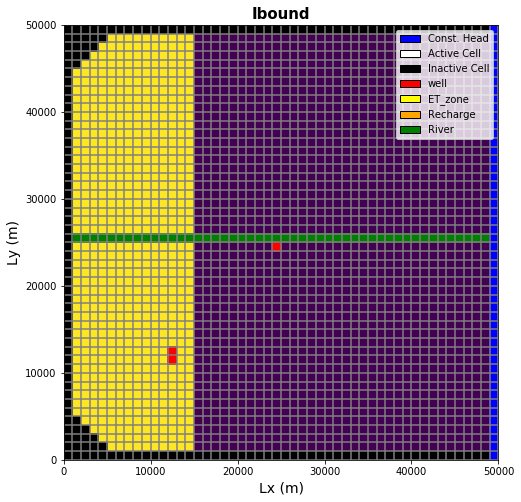

In [141]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
#zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(rech_zone_forced)
#quadmesh = modelmap.plot_array(rech_zone_forced)

riv_plot = modelmap.plot_bc(ftype='RIV')
quadmesh = modelmap.plot_ibound(ibound[0])
wel = modelmap.plot_bc(ftype='WEL')
#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
#riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound()



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')

### Gridded domain plot

In [142]:
# fig = plt.figure(figsize=(15, 5))
# ax = fig.add_subplot(1, 1, 1)

# xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 25}) #note use the key 'column' if you want to plot a column instaed
# patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# # linecollection = xsect.plot_grid(color='green')
# # t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

# pc = xsect.plot_array(head['sp1200'], masked_values=[-999.99], head=head, alpha=0.5)
# patches = xsect.plot_ibound(head=head['sp1200'])
# #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
# #patches = xsect.plot_bc('WEL', color='red')
# linecollection = xsect.plot_grid(color='black', lw=0.5)
# t = ax.set_title('3 Layer Model Row 25 Cross-Section')
# cb = plt.colorbar(pc, shrink=0.75)
# #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
# wt = xsect.plot_surface(head['sp200'][0,:,:], masked_values=[999.], color='blue', lw=1)

## Plotting Heads

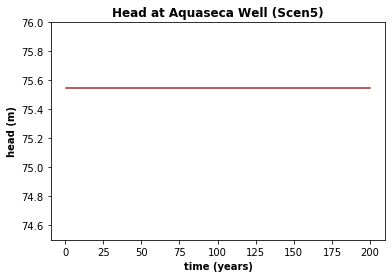

In [155]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Aquaseca Well (Scen5)",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.ylim(74.5,76)
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-', color="brown") #plot the time series with points at each record

plt.savefig("Head_Aqua5.png",dpi=600)
plt.show()


In [144]:
from numpy import asarray
from numpy import savetxt

np.savetxt("top_head_spinup_200yr.csv", head['sp%s'%(len(head)-1)][0], delimiter=",")
np.savetxt("mid_head_spinup_200yr.csv", head['sp%s'%(len(head)-1)][1], delimiter=",")
np.savetxt("bot_head_spinup_200yr.csv", head['sp%s'%(len(head)-1)][2], delimiter=",")

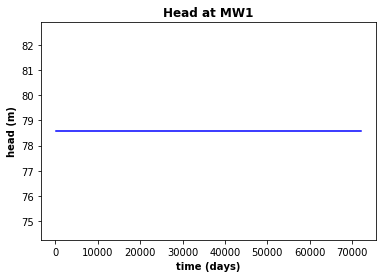

In [156]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well2_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at MW1",fontweight='bold')
plt.xlabel('time (days)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0], time_series1[:, 1], 'b-') #plot the time series with points at each record
# plt.plot(time_series1[900:, 0], time_series1[900:, 1], 'b-') #less data

plt.savefig("Head_M1_5.png",dpi=600)
plt.show()


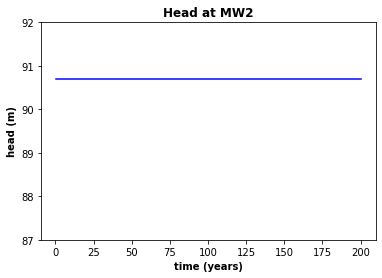

In [157]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well3_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at MW2",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.ylim(87, 92)
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-') #plot the time series with points at each record

plt.savefig("Head_M2_5png", dpi=600)
plt.show()


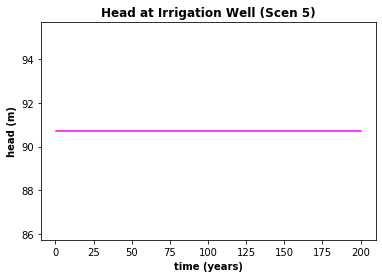

In [158]:

#plot a time series at cell left of river
#get time series for cell

cell_id1 = well4_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Irrigation Well (Scen 5)",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
#plt.ylim(89, 92)
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-', color="magenta") #plot the time series with points at each record

plt.savefig("Head_irri5.png", dpi=600)
plt.show()


### Leakage calculation

In [148]:
well_loc
head['sp0'][0][19][38]
#head['sp0'][well_loc[0]][well_loc[1]][well_loc[2]]

#budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
#leakage = budgobj.get_data(text='RIVER LEAKAGE')
#print(leakage[0])
perflux = np.array(range(nper))

for i in range(nper-1):
    ##print("Stream Leakage for Stress period %s"%i)
    perflux[i] = 0
    for k in range(len(leakage['sp%s'%i][0])):
        #print(leakage['sp%s'%i][0][k][1])
        perflux[i] = perflux[i] + leakage['sp%s'%i][0][k][1]
        #flux[i] = flux[i] + leakage[0][k][1]
    
print(perflux)    


[12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757 12757
 12757 12757 12757 12757 12757 12757 12757 12757 12

## Water Budget calculations

In [149]:
print(len(head))
##STream Leakage

t2 = max(enumerate(times))
t = t2[0] - 12
print(t)
leak = 0
for i in range(12):
    leak = leak + np.sum(leakage['sp%s'%(t+i)][0].q)
print("Total stream leakge at year 100:")    
print(leak)   
# t = 0
# ileak = 0
# for i in range(12):
#     ileak = ileak + np.sum(leakage['sp%s'%(t+i)][0].q)
    
# print(int(ileak))    

##GW outflow
t = t2[0] - 12
print(t)
frf_total = 0
for k in range(nlay):
    for i in range(12):
        frf_total = frf_total + np.sum(frf['sp%s'%(t+i)][0][k][:][48])

print("Total GW outflow 100 year:")
print(frf_total)
#print(np.sum(leakage['sp0'][0].q) - np.sum(leakage['sp1199'][0].q))

## ET
t = t2[0] - 12
print(t)
ET_total = 0
for i in range(12):
       ET_total = ET_total + np.sum(np.sum(et['sp%s'%(t+i)][0][1][:][:]))
print("Total ET at year 100:")
print(ET_total) 

## Recharge
t = t2[0] - 12
print(t)
rech_total = 0
for i in range(12):
       rech_total = rech_total + np.sum(np.sum(recharge['sp%s'%(t+i)][0][1][:][:]))
print("Total rech at year 100:")
print(rech_total)     


400
387
Total stream leakge at year 100:
153332.1796875
387
Total GW outflow 100 year:
219674.2529296875
387
Total ET at year 100:
-200033.671875
387
Total rech at year 100:
312960.0


### Testing stuff

In [19]:
type(times)
len(times)


1200

In [20]:
oc_spd = {}
for kper in range(1,nper): #nper is 201, this is the key for each entry in oc_spd dict
    oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
    oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfoc.ModflowOc'> <class 'flopy.modflow.mfoc.ModflowOc'>
replacing existing Package...


### Storage

In [21]:
# #testing things
# type(stor)
# stor.keys()
# #stor.values()

# type(stor["sp1"])
# print(stor["sp1"])

# SUM=(sum(stor["sp1"]))
# print(SUM)

# print(stor['sp1'][0][0].shape)

# startlay0 = (stor['sp0'][0][0])
# startlay1 = (stor['sp0'][0][1])
# startlay2 = (stor['sp0'][0][2])
# start_stor = startlay0 + startlay1 + startlay2
# print(start_stor.sum())

# endlay0 = (stor['sp1199'][0][0])
# endlay1 = (stor['sp1199'][0][1])
# endlay2 = (stor['sp1199'][0][2])
# end_stor = endlay0 + endlay1 + endlay2
# print(end_stor.sum())

#storage change
storage_change = 0
for i in range(sim_years*sp_peryr*nstp[0]):
    storage_i = stor['sp%s'%(i)][0][:].sum()
    storage_change = storage_change + storage_i
print(storage_change)

#yearly storage
yearly_stor = {}
storage_change = 0
yearlist = list(range(100))
for i in range(len(yearlist)):
    yearlist[i] = yearlist[i]*12
#print(yearlist)

for i in yearlist:
    storage_change = 0
    for sp in range(12):
        timestep = i + sp
        storage_i = stor['sp%s'%(timestep)][0][:].sum()
        storage_change = storage_change + storage_i
        #print(storage_change)
        if sp == 11:
            yearly_stor[i/12] = storage_change
            print('year', i/12, storage_change)
            
            
#more storage stuff
storage_tot = 0
for i in range(100):
    storage_tot = storage_tot + yearly_stor[i]
    
print(storage_tot)
print(0.000810714*storage_tot)


yearlist2 = list(range(100))
print(yearlist2)
print(type(yearly_stor))
stor_ls = []
for i in range(100):
    stor_ls.append(yearly_stor[i])
  

3406992.541015625
year 0.0 52568.774841308594
year 1.0 53307.24133300781
year 2.0 53477.16613769531
year 3.0 53309.181213378906
year 4.0 52882.550048828125
year 5.0 52282.66223144531
year 6.0 51577.130432128906
year 7.0 50806.053649902344
year 8.0 50003.873779296875
year 9.0 49198.143005371094
year 10.0 50633.519287109375
year 11.0 49675.780700683594
year 12.0 48769.12548828125
year 13.0 47902.353271484375
year 14.0 47069.660400390625
year 15.0 46267.187255859375
year 16.0 45490.32568359375
year 17.0 44737.97900390625
year 18.0 44013.84704589844
year 19.0 43306.18127441406
year 20.0 44960.17614746094
year 21.0 44117.124267578125
year 22.0 43334.17333984375
year 23.0 42592.10241699219
year 24.0 41876.972900390625
year 25.0 41182.87609863281
year 26.0 40508.42517089844
year 27.0 39856.90051269531
year 28.0 39221.950927734375
year 29.0 38602.66467285156
year 30.0 40442.97229003906
year 31.0 39670.734375
year 32.0 38957.60009765625
year 33.0 38277.56774902344
year 34.0 37621.15234375
year 

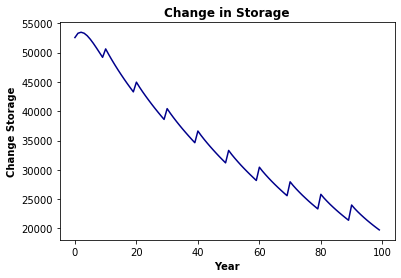

In [22]:
plt.subplot(1, 1, 1)
plt.title("Change in Storage",fontweight='bold')
plt.xlabel('Year',fontweight='bold')
plt.ylabel('Change Storage',fontweight='bold')
plt.plot(yearlist2, stor_ls, 'b-', color="darkblue") #plot the time series with points at each record
# plt.savefig('storage.png', dpi=600)
plt.show()


#### Cumulative storage

In [23]:
cum_storage_ls = []
cum_storage = 0
for i in range(100):
    cum_storage = cum_storage + yearly_stor[i]
    cum_storage_ls.append(cum_storage)
    

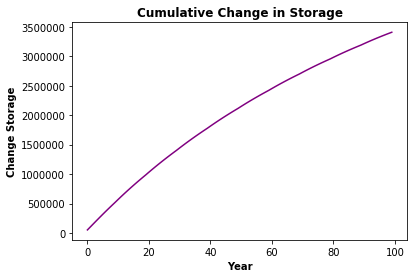

In [24]:
plt.subplot(1, 1, 1)
plt.title("Cumulative Change in Storage",fontweight='bold')
plt.xlabel('Year',fontweight='bold')
plt.ylabel('Change Storage',fontweight='bold')
plt.plot(yearlist2, cum_storage_ls, 'b-', color="purple") #plot the time series with points at each record
# plt.savefig('cumstorage.png', dpi=600)
plt.show()

## Modpath

In [25]:
moddirmp="/Applications/MODFLOW/mp7"
#moddirmp="/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mp7"

mpname=os.path.join(modelname + '_mp')

#Set the range of cell to add particles to [layerstart, rowstart, colstart,  layerend, rowend,  colend]
locsb = [[0, 28, 18, 0, 30, 20]]
#locsb = [[0, 0, 0, 0, 49, 49]]
#set the number of particles per cell
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=2, rowcelldivisions=2, layercelldivisions=2)
#setup theparticles
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd], lrcregions=[locsb])
pg = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG1',particledata=p,filename='ex01a.pg1.sloc')
particlegroups = [pg]

defaultiface = {'RECHARGE': 6, 'ET': 6}

#setup  the modpath packages
mp = flopy.modpath.Modpath7(modelname=modelname + '_mp', flowmodel=m, exe_name=moddirmp)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=n, defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='stop_at',
                                  weaksourceoption='stop_at',
                                  budgetoutputoption='summary',
                                  stoptimeoption='total', 
                                  particlegroups= particlegroups)

mp.add_package(rch) # write modpath datasets

mp.write_input()

# run modpath
mp.run_model()

mp.get_package_list()

FloPy is using the following  executable to run the model: /Applications/MODFLOW/mp7

MODPATH Version 7.2.001   
Program compiled Jan 30 2020 15:01:33 with GFORTRAN compiler (ver. 9.2.0)       


Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  3.00000E+01  Transient flow                                                       
Processing Time Step     2 Period     1.  Time =  6.00000E+01  Transient flow                                                       
Processing Time Step     3 Period     1.  Time =  9.00000E+01  Transient flow                                                       
Processing Time Step     4 Period     1.  Time =  1.20000E+02  Transient flow                                                       
Processing Time Step     5 Period     1.  Time =  1.50000E+02  Transient flow                                                       
Processing Time Step     6 Period     1.  Time =  1.80000E+02  Transient flow                         

Processing Time Step     4 Period    12.  Time =  2.10000E+03  Transient flow                                                       
Processing Time Step     5 Period    12.  Time =  2.13000E+03  Transient flow                                                       
Processing Time Step     6 Period    12.  Time =  2.16000E+03  Transient flow                                                       
Processing Time Step     1 Period    13.  Time =  2.19000E+03  Transient flow                                                       
Processing Time Step     2 Period    13.  Time =  2.22000E+03  Transient flow                                                       
Processing Time Step     3 Period    13.  Time =  2.25000E+03  Transient flow                                                       
Processing Time Step     4 Period    13.  Time =  2.28000E+03  Transient flow                                                       
Processing Time Step     5 Period    13.  Time =  2.31000E+03  Transi

Processing Time Step     1 Period    29.  Time =  5.07000E+03  Transient flow                                                       
Processing Time Step     2 Period    29.  Time =  5.10000E+03  Transient flow                                                       
Processing Time Step     3 Period    29.  Time =  5.13000E+03  Transient flow                                                       
Processing Time Step     4 Period    29.  Time =  5.16000E+03  Transient flow                                                       
Processing Time Step     5 Period    29.  Time =  5.19000E+03  Transient flow                                                       
Processing Time Step     6 Period    29.  Time =  5.22000E+03  Transient flow                                                       
Processing Time Step     1 Period    30.  Time =  5.25000E+03  Transient flow                                                       
Processing Time Step     2 Period    30.  Time =  5.28000E+03  Transi

Processing Time Step     5 Period    45.  Time =  8.07000E+03  Transient flow                                                       
Processing Time Step     6 Period    45.  Time =  8.10000E+03  Transient flow                                                       
Processing Time Step     1 Period    46.  Time =  8.13000E+03  Transient flow                                                       
Processing Time Step     2 Period    46.  Time =  8.16000E+03  Transient flow                                                       
Processing Time Step     3 Period    46.  Time =  8.19000E+03  Transient flow                                                       
Processing Time Step     4 Period    46.  Time =  8.22000E+03  Transient flow                                                       
Processing Time Step     5 Period    46.  Time =  8.25000E+03  Transient flow                                                       
Processing Time Step     6 Period    46.  Time =  8.28000E+03  Transi

Processing Time Step     2 Period    62.  Time =  1.10400E+04  Transient flow                                                       
Processing Time Step     3 Period    62.  Time =  1.10700E+04  Transient flow                                                       
Processing Time Step     4 Period    62.  Time =  1.11000E+04  Transient flow                                                       
Processing Time Step     5 Period    62.  Time =  1.11300E+04  Transient flow                                                       
Processing Time Step     6 Period    62.  Time =  1.11600E+04  Transient flow                                                       
Processing Time Step     1 Period    63.  Time =  1.11900E+04  Transient flow                                                       
Processing Time Step     2 Period    63.  Time =  1.12200E+04  Transient flow                                                       
Processing Time Step     3 Period    63.  Time =  1.12500E+04  Transi

Processing Time Step     2 Period    78.  Time =  1.39200E+04  Transient flow                                                       
Processing Time Step     3 Period    78.  Time =  1.39500E+04  Transient flow                                                       
Processing Time Step     4 Period    78.  Time =  1.39800E+04  Transient flow                                                       
Processing Time Step     5 Period    78.  Time =  1.40100E+04  Transient flow                                                       
Processing Time Step     6 Period    78.  Time =  1.40400E+04  Transient flow                                                       
Processing Time Step     1 Period    79.  Time =  1.40700E+04  Transient flow                                                       
Processing Time Step     2 Period    79.  Time =  1.41000E+04  Transient flow                                                       
Processing Time Step     3 Period    79.  Time =  1.41300E+04  Transi

Processing Time Step     5 Period    93.  Time =  1.67100E+04  Transient flow                                                       
Processing Time Step     6 Period    93.  Time =  1.67400E+04  Transient flow                                                       
Processing Time Step     1 Period    94.  Time =  1.67700E+04  Transient flow                                                       
Processing Time Step     2 Period    94.  Time =  1.68000E+04  Transient flow                                                       
Processing Time Step     3 Period    94.  Time =  1.68300E+04  Transient flow                                                       
Processing Time Step     4 Period    94.  Time =  1.68600E+04  Transient flow                                                       
Processing Time Step     5 Period    94.  Time =  1.68900E+04  Transient flow                                                       
Processing Time Step     6 Period    94.  Time =  1.69200E+04  Transi

Processing Time Step     1 Period   110.  Time =  1.96500E+04  Transient flow                                                       
Processing Time Step     2 Period   110.  Time =  1.96800E+04  Transient flow                                                       
Processing Time Step     3 Period   110.  Time =  1.97100E+04  Transient flow                                                       
Processing Time Step     4 Period   110.  Time =  1.97400E+04  Transient flow                                                       
Processing Time Step     5 Period   110.  Time =  1.97700E+04  Transient flow                                                       
Processing Time Step     6 Period   110.  Time =  1.98000E+04  Transient flow                                                       
Processing Time Step     1 Period   111.  Time =  1.98300E+04  Transient flow                                                       
Processing Time Step     2 Period   111.  Time =  1.98600E+04  Transi

Processing Time Step     5 Period   125.  Time =  2.24700E+04  Transient flow                                                       
Processing Time Step     6 Period   125.  Time =  2.25000E+04  Transient flow                                                       
Processing Time Step     1 Period   126.  Time =  2.25300E+04  Transient flow                                                       
Processing Time Step     2 Period   126.  Time =  2.25600E+04  Transient flow                                                       
Processing Time Step     3 Period   126.  Time =  2.25900E+04  Transient flow                                                       
Processing Time Step     4 Period   126.  Time =  2.26200E+04  Transient flow                                                       
Processing Time Step     5 Period   126.  Time =  2.26500E+04  Transient flow                                                       
Processing Time Step     6 Period   126.  Time =  2.26800E+04  Transi

Processing Time Step     1 Period   142.  Time =  2.54100E+04  Transient flow                                                       
Processing Time Step     2 Period   142.  Time =  2.54400E+04  Transient flow                                                       
Processing Time Step     3 Period   142.  Time =  2.54700E+04  Transient flow                                                       
Processing Time Step     4 Period   142.  Time =  2.55000E+04  Transient flow                                                       
Processing Time Step     5 Period   142.  Time =  2.55300E+04  Transient flow                                                       
Processing Time Step     6 Period   142.  Time =  2.55600E+04  Transient flow                                                       
Processing Time Step     1 Period   143.  Time =  2.55900E+04  Transient flow                                                       
Processing Time Step     2 Period   143.  Time =  2.56200E+04  Transi

Processing Time Step     4 Period   158.  Time =  2.83800E+04  Transient flow                                                       
Processing Time Step     5 Period   158.  Time =  2.84100E+04  Transient flow                                                       
Processing Time Step     6 Period   158.  Time =  2.84400E+04  Transient flow                                                       
Processing Time Step     1 Period   159.  Time =  2.84700E+04  Transient flow                                                       
Processing Time Step     2 Period   159.  Time =  2.85000E+04  Transient flow                                                       
Processing Time Step     3 Period   159.  Time =  2.85300E+04  Transient flow                                                       
Processing Time Step     4 Period   159.  Time =  2.85600E+04  Transient flow                                                       
Processing Time Step     5 Period   159.  Time =  2.85900E+04  Transi

Processing Time Step     4 Period   174.  Time =  3.12600E+04  Transient flow                                                       
Processing Time Step     5 Period   174.  Time =  3.12900E+04  Transient flow                                                       
Processing Time Step     6 Period   174.  Time =  3.13200E+04  Transient flow                                                       
Processing Time Step     1 Period   175.  Time =  3.13500E+04  Transient flow                                                       
Processing Time Step     2 Period   175.  Time =  3.13800E+04  Transient flow                                                       
Processing Time Step     3 Period   175.  Time =  3.14100E+04  Transient flow                                                       
Processing Time Step     4 Period   175.  Time =  3.14400E+04  Transient flow                                                       
Processing Time Step     5 Period   175.  Time =  3.14700E+04  Transi

Processing Time Step     6 Period   190.  Time =  3.42000E+04  Transient flow                                                       
Processing Time Step     1 Period   191.  Time =  3.42300E+04  Transient flow                                                       
Processing Time Step     2 Period   191.  Time =  3.42600E+04  Transient flow                                                       
Processing Time Step     3 Period   191.  Time =  3.42900E+04  Transient flow                                                       
Processing Time Step     4 Period   191.  Time =  3.43200E+04  Transient flow                                                       
Processing Time Step     5 Period   191.  Time =  3.43500E+04  Transient flow                                                       
Processing Time Step     6 Period   191.  Time =  3.43800E+04  Transient flow                                                       
Processing Time Step     1 Period   192.  Time =  3.44100E+04  Transi

['MPBAS', 'MPSIM', 'RCH']

### Read in Modpath outputs

In [26]:
#load in the flow path file
fpth = os.path.join(mpname + '.mppth')
p = flopy.utils.PathlineFile(fpth)

#load in the end point file
fpth = os.path.join(mpname + '.mpend')
e = flopy.utils.EndpointFile(fpth, verbose=False)

#make a subset which is all the particles
pall = p.get_alldata()  #formerly pwb and ewb
eall = e.get_alldata()

#make a subset which is particles ending in the Aquaseca well
nodewell = m.dis.get_node([(2, well_row, well_col)])
print(nodewell)
pwell1 = p.get_destination_pathline_data(dest_cells=nodewell)
ewell1 = e.get_destination_endpoint_data(dest_cells=nodewell)

#make a subset which is particles ending in the irrigation well
nodewell4 = m.dis.get_node([(0, well4_row, well4_col)])
print(nodewell4)
pwell4 = p.get_destination_pathline_data(dest_cells=nodewell4)
ewell4 = e.get_destination_endpoint_data(dest_cells=nodewell4)

print(pall)

ValueError: could not convert string to float: '0.22478670-309'

### Plotting particles

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

ax.set_aspect('equal')
ax.set_title('Flowlines')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pall, layer='all', color='blue', lw=0.5, linestyle=':', label='not captured by wells') #,marker='o', markercolor='black', markersize=3, markerevery=5)
# mm.plot_pathline(pwell1, layer='all', color='red', lw=0.5, linestyle=':', label='Aquaseca well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
# mm.plot_pathline(pwell4, layer='all', color='green', lw=0.5, linestyle=':', label='Irrigation well') # ,marker='o', markercolor='black', markersize=3, markerevery=5)
# # mm.ax.legend();
#plt.tight_layout();
# plt.savefig('Pathlines1.png', dpi=600)